Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.1272 - val_loss: 0.0536
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0563 - val_loss: 0.0508
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0537 - val_loss: 0.0487
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0518 - val_loss: 0.0470
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0502 - val_loss: 0.0459
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0494 - val_loss: 0.0454
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0486 - val_loss: 0.0446
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0481 - val_loss: 0.0441
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0476 - val_loss: 0.0436
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0474 - val_loss: 0.0430
Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0472 - val_loss: 0.0430
Epoch 12/20
1000/1000 ━━━━━━━

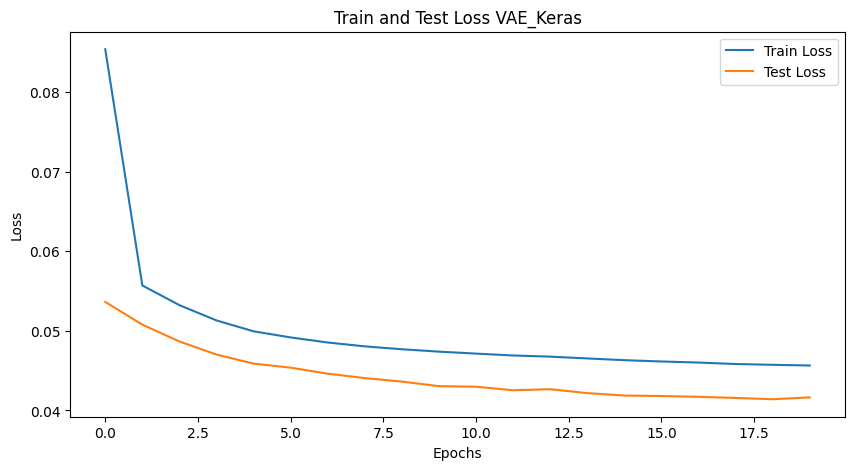

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


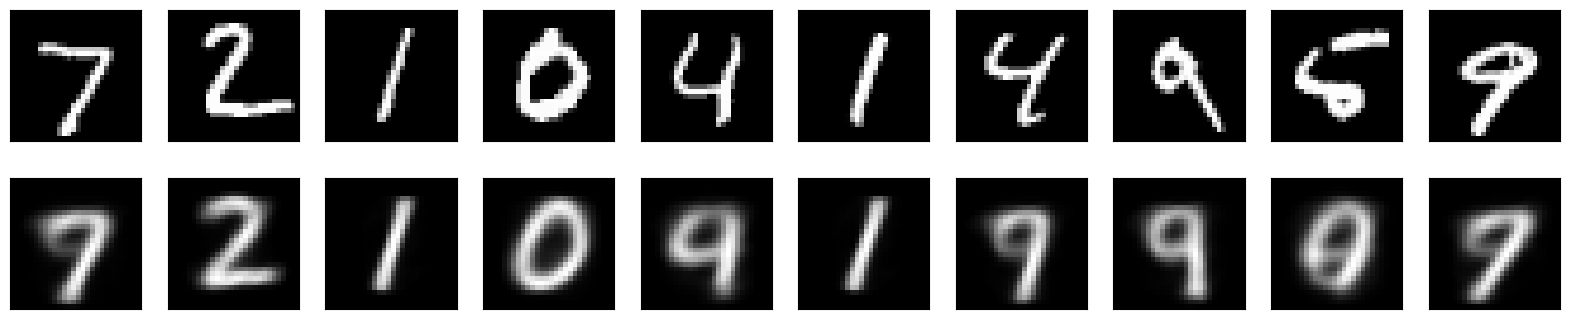

In [4]:
# СОСНЮК КАТЕРИНА ФІТ 4-6 ВАРІАНТ 22 
# Розробитии варіаційний автокодувальник для датасету рукописних цифр MNIST на основі багатошарової моделі
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

hidden_dim = 2
batch_size = 60

def dropout_and_batch(x):
    return Dropout(0.3)(BatchNormalization()(x))

input_img = Input((28, 28, 1))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)

z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

def noiser(args):
    global z_mean, z_log_var
    z_mean, z_log_var = args
    batch_size = tf.shape(z_mean)[0]  
    N = tf.random.normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)  
    return tf.exp(z_log_var / 2) * N + z_mean 

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])
input_dec = Input(shape=(hidden_dim,))
d = Dense(128, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(256, activation='relu')(d)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = keras.Model(input_img, h, name='encoder')
decoder = keras.Model(input_dec, decoded, name='decoder')
vae = keras.Model(input_img, decoder(encoder(input_img)), name="vae")

kl_weight = 0.0001  

def vae_loss(x, y):
    x = tf.reshape(x, shape=(-1, 28*28))  
    y = tf.reshape(y, shape=(-1, 28*28))  
    loss = tf.reduce_mean(tf.square(x-y)) 
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)  
    return loss + kl_weight * kl_loss

vae.compile(optimizer='adam', loss=vae_loss)


history = vae.fit(x_train, x_train, epochs=20, batch_size=batch_size, shuffle=True, validation_data=(x_test, x_test))

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss VAE_Keras')
plt.legend()
plt.show()

n = 10

imgs = x_test[:n]
decoded_imgs = vae.predict(x_test[:n], batch_size=n)

plt.figure(figsize=(2*n, 2*2))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax2 = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

plt.show()


In [6]:
# ВИСНОВКИ
# За даними отриманими в результаті виконання лабораторної роботи, варіаційний автокодувальник має найменшу кінцеву втрату і найкращі показники 
# зменшення втрати під час навчання. 
# Однак, звичайні автокодувальники зі згортковими шарами та багатошаровою нейронною мережею також показують досить хороші результати.
# Якщо порівнювати швидкість навчання, багатошарова нейронна мережа навчається найшвидше (8s на епоху), але втрата залишається досить великою. 
# Звичайний автокодувальник зі згортковими шарами має той же час навчання на епоху, що і варіаційний автокодувальник, але його кінцева втрата трохи більша.
# Отже, якщо мета - це зменшення втрати, варіаційний автокодувальник є найкращим вибором. 
# Проте багатошарова нейронна мережа і звичайний автокодувальник зі згортковими шарами мають прийнятні результати, особливо якщо швидкість навчання важлива.